In [10]:
from fastai.conv_learner import *
from fastai.dataset import *
from tqdm import tqdm 
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
import math

In [11]:
# Set paths to dataset
TRAIN = "../original_data/train"
TEST = "../original_data/test"
LABELS = "../original_data/train.csv"
SAMPLE_SUB = "../original_data/sample_submission.csv"

In [12]:
arch = resnet50
nw = 4

In [13]:
# prepare the dataset to work with Fastai pipeline
train_df = pd.read_csv(LABELS).set_index('Image')
#print(train_df)
unique_labels = np.unique(train_df.Id.values)
#len(unique_labels)
labels_dict = dict()
labels_list = []
for i in range(len(unique_labels)):
    labels_dict[unique_labels[i]] = i
    labels_list.append(unique_labels[i])
#labels_list
print("Number of classes: {}".format(len(unique_labels)))
# convert from w_a1o23whatever into our own index
train_names = train_df.index.values
train_df.Id = train_df.Id.apply(lambda x: labels_dict[x])
#print(train_df)
train_labels = np.asarray(train_df.Id.values)
train_labels
test_names = [f for f in os.listdir(TEST)]

Number of classes: 5005


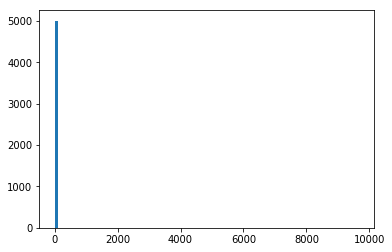

In [14]:
# plot a histogram of sample-per-class distribution
labels_count = train_df.Id.value_counts()
#print(labels_count)
_, _, _ = plt.hist(labels_count, bins=100)
#labels_count

Count for class new_whale / 0 : 9664


(array([   0.,    0.,    0.,    0., 2073.,    0.,    0.,    0., 1285.,    0.,    0.,    0.,  568.,    0.,
           0.,    0.,  273.,    0.,    0.,    0.,  172.,    0.,    0.,    0.,  136.,    0.,    0.,    0.,
          86.,    0.,    0.,    0.,   76.,    0.,    0.,    0.,   62.,    0.,    0.,    0.,   46.,    0.,
           0.,    0.,   39.,    0.,    0.,    0.,   26.,    0.,    0.,    0.,   14.,    0.,    0.,    0.,
          16.,    0.,    0.,    0.,   19.,    0.,    0.,    0.,   16.,    0.,    0.,    0.,   17.,    0.,
           0.,    0.,    6.,    0.,    0.,    0.,    8.,    0.,    0.,    0.,    7.,    0.,    0.,    0.,
           7.,    0.,    0.,    0.,    5.,    0.,    0.,    0.,    4.,    0.,    0.,    0.,    7.,    0.,
           0.,    2.]),
 array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,
         3.5 ,  3.75,  4.  ,  4.25,  4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,
         7.  ,  7.25, 

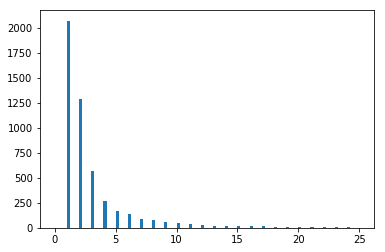

In [15]:
# we can see that the histogram does not show anything good because of new_whale many examples
print("Count for class new_whale / 0 : {}".format(labels_count[0]))

plt.hist(labels_count[1:], bins = 100, range=[0, 25])

In [16]:
print(train_names)

['0000e88ab.jpg' '0001f9222.jpg' '00029d126.jpg' ... 'fff9002e0.jpg' 'fffcde6fe.jpg' 'fffde072b.jpg']


In [17]:
# we need to duplicate examples because there are many classes with just one example
dup = []
for idx, row in train_df.iterrows():
    if labels_count[row['Id']] < 5:
        dup.extend([idx]*math.ceil((5 - labels_count[row['Id']])/labels_count[row['Id']]))
train_names = np.concatenate([train_names, dup])
#print(len(train_names))
train_names = train_names[np.random.RandomState(seed=50).permutation(train_names.shape[0])]
print(len(train_names))

41589


In [18]:
# Split training data into train and validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1,random_state=42069)
for train_idx, val_idx in sss.split(train_names, np.zeros(train_names.shape)):
    tr_n, val_n = train_names[train_idx], train_names[val_idx]
print(len(tr_n), len(val_n))

37430 4159


In [19]:
# Let's see the dimensions (height, width) of images
avg_width = 0
avg_height = 0
for fn in os.listdir(TRAIN)[:1000]:
    img = cv2.imread(os.path.join(TRAIN,fn))
    avg_width += img.shape[1]
    avg_height += img.shape[0]

avg_width //= 1000
avg_height //= 1000
print(avg_width, avg_height)

1011 522


In [20]:
class HWIDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.train_df = train_df
        super().__init__(fnames, transform, path)
        
    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        img = cv2.resize(img, (self.sz, self.sz))
        return img
    
    def get_y(self, i):
        if(self.path == TEST): return 0
        return self.train_df.loc[self.fnames[i]]['Id']
    
    def get_c(self):
        return len(unique_labels)

In [21]:
class RandomLightning(Transform):
    def __init__(self, b, c, tfm_y=TfmType.NO):
        super().__init__(tfm_y)
        self.b, self.c = b, c
        
    def set_state(self):
        self.store.b_rand = rand0(self.b)
        self.store.c_rand = rand0(self.c)
        
    def do_transform(self, x, is_y):
        if is_y and self.tfm_y != TfmType.PIXEL: return x
        b = self.store.b_rand
        c = self.store.c_rand
        c = -1 / (c-1) if c < 0 else c + 1
        x = lighting(x, b, c)
        return x
    
def get_data(sz, bs):
    aug_tfms = [RandomRotateZoom(deg=20, zoom=2, stretch=1),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO),
                RandomBlur(blur_strengths=3, tfm_y=TfmType.NO),
                RandomFlip(tfm_y=TfmType.NO)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=aug_tfms)
    ds = ImageData.get_ds(HWIDataset, (tr_n[:-(len(tr_n) % bs)], TRAIN), (val_n, TRAIN), tfms, test=(test_names, TEST))
    md = ImageData("./", ds, bs, num_workers=nw, classes=None)
    return md

In [22]:
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
#os.environ["CUDA_VISIBLE_DEVICES"]="2"
#torch.cuda.set_device(1)
batch_size = 64
md = get_data(avg_width//4, batch_size)
learn = ConvLearner.pretrained(arch, md)
learn.opt_fn = optim.Adam

In [ ]:
learn.lr_find()
learn.sched.plot()

In [14]:
lr = 5e-3
#torch.cuda.set_device(0)

In [21]:
learn.fit(lr, 1, cycle_len=2)
#learn.unfreeze()
#lrs = np.array([lr/10, lr/20, lr/40])
#learn.fit(lrs, 4, cycle_len=4, use_clr=(20, 16))
#learn.fit(lrs/4, 2, cycle_len=4, use_clr=(10, 16))
#learn.fit(lrs/16, 1, cycle_len=4, use_clr=(10, 16))

epoch      trn_loss   val_loss   accuracy                   
    0      7.000143   204.3842   0.160616  
    1      6.320342   9.372991   0.247175                   



[array([9.37299]), 0.24717480170308298]

In [26]:
preds_t,y_t = learn.TTA(is_test=True,n_aug=8)
preds_t = np.stack(preds_t, axis=-1)
preds_t = np.exp(preds_t)
preds_t = preds_t.mean(axis=-1)
np.save("preds_resnet50.npy",preds_t)

In [27]:
MODEL_PATH = 'Resnet50_v1'
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.Image)
pred_list = [[labels_list[i] for i in p.argsort()[-5:][::-1]] for p in preds_t]
pred_dic = dict((key, value) for (key, value) in zip(learn.data.test_ds.fnames,pred_list))
pred_list_cor = [' '.join(pred_dic[id]) for id in sample_list]
df = pd.DataFrame({'Image':sample_list,'Id': pred_list_cor})
df.to_csv('submission.csv'.format(MODEL_PATH), header=True, index=False)
df.head()

,Image,Id
0,00028a005.jpg,new_whale w_36bbd71 w_d72771c w_e6264df w_c875e45
1,000dcf7d8.jpg,new_whale w_6e7763b w_e3956f5 w_f7cd240 w_d907b6c
2,000e7c7df.jpg,new_whale w_c4862bb w_4689352 w_a743e09 w_15951db
3,0019c34f4.jpg,w_9c506f6 w_59052ad w_08630fd w_8b86b95 w_0135f5f
4,001a4d292.jpg,w_8c56684 w_3d67c3b w_9e18daa w_1fc4625 w_58ddf90


In [18]:
len(df)

7960

In [19]:
# Save the model
learn.save("resnet50_v1")

In [25]:
# Load the model
learn.load("resnet50_v1")